# Exploring an Ecommerce Dataset exported from Google Analytics

## 1. Goals
### 1.1. Exploratory data analysis
* Number of views and number of unique users
* Top ten products with the most views
* Top top 10 selling products
* Number of different eCommerceAction_type
* Calculate revenue by month
* How many % of the total visitors made a purchase?
* How many visitors bought on subsequent visits to the website?

### 1.2. Predictive analysis

There are customers who add products to carts but they removed the products from the carts or logged out without further processing. The customers don't complete the purchases. I try to create a LM model to predict whether the customers will complete the purchases after adding products to carts.

## 2. Data

The public dataset in BigQuery is exported from Google Analytics 360 data from the Google Merchandise Store. For more information, click [Here](https://console.cloud.google.com/marketplace/product/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset&q=ecommerce&id=45f150ac-81d3-4796-9abf-d7a4f98eb4c6&project=qwiklabs-gcp-04-42fd9c021ec6&folder=&organizationId=). The data includes the following information:
* Traffic source data: information about where website visitors originate, including data about organic traffic, paid search traffic, and display traffic
* Content data: information about the behavior of users on the site, such as URLs of pages that visitors look at, how they interact with content, etc.
* Transactional data: information about the transactions on the Google Merchandise Store website.

## 3. Method
I use Google Bigquery and Chart inside Notebook in DataLab to perform the exploratory data analysis and ML classification model. Logistic regression which is supported inside Bigquery is selected for the classification model. 

## Results

The results from the exploratory data analysis are shown in the tables and plots in the code attached below. The value of _roc-auc_ in the classification model is about 0.7. 

## Requirement

One needs a GCP account to access Google Bigquery and DataLab. This public dataset is hosted in Google BigQuery and is included in BigQuery's 1TB/mo of free tier processing. 

# Code

In [1]:
import google.datalab.bigquery as bq

#  1. Exploring an Ecommerce Dataset using SQL in Google BigQuery and Google charts

## 1.1. Check the table

In [2]:
%bq sample -t data-to-insights.ecommerce.web_analytics

visitorId,visitNumber,visitId,visitStartTime,date,fullVisitorId,userId,channelGrouping,socialEngagementType
,1,1487190114,1487190114,20170215,8408031500083978531,,Organic Search,Not Socially Engaged
,1,1485809661,1485809661,20170130,7061885047362906241,,Organic Search,Not Socially Engaged
,1,1483535577,1483535577,20170104,9687855392373820534,,Referral,Not Socially Engaged
,1,1499576978,1499576978,20170708,8503872733389952374,,Organic Search,Not Socially Engaged
,1,1488033918,1488033918,20170225,9242429596082250579,,Direct,Not Socially Engaged
,4,1488051699,1488051699,20170225,7763513503212702426,,Organic Search,Not Socially Engaged
,2,1481956581,1481956581,20161216,0770008669576303961,,Organic Search,Not Socially Engaged
,4,1486061252,1486061252,20170202,9629306859860137992,,Organic Search,Not Socially Engaged
,1,1482422496,1482422496,20161222,9209125991191286753,,Organic Search,Not Socially Engaged
,1,1478836940,1478836940,20161110,6779453303186209530,,Direct,Not Socially Engaged


## 1.2 Check the table schema

In [3]:
%bq tables describe -n data-to-insights.ecommerce.web_analytics

## 1.3. Number of views and number of unique users

In [4]:
%bq query
SELECT
  COUNT(*) as product_views,
  COUNT(distinct fullVisitorId) as unique_user
FROM `data-to-insights.ecommerce.web_analytics`

product_views,unique_user
970532,741721


## 1.4. List of ten product with the most views

In [5]:
%bq query -n most_viewed_products
SELECT
  COUNT(*) as product_views,
  hp.v2ProductName as product_name
FROM `data-to-insights.ecommerce.web_analytics`, UNNEST(hits) as h, UNNEST(h.product) as hp
GROUP BY product_name
ORDER BY product_views DESC
LIMIT 10

In [6]:
%bq execute -q most_viewed_products


product_views,product_name
339308,Google Men's 100% Cotton Short Sleeve Hero Tee White
226598,22 oz YouTube Bottle Infuser
218033,YouTube Men's Short Sleeve Hero Tee Black
211818,YouTube Custom Decals
211673,Google Men's 100% Cotton Short Sleeve Hero Tee Black
206783,Google Men's 100% Cotton Short Sleeve Hero Tee Navy
201083,YouTube Twill Cap
197361,YouTube Men's Short Sleeve Hero Tee Charcoal
193925,Electronics Accessory Pouch
173616,Google Men's Watershed Full Zip Hoodie Grey


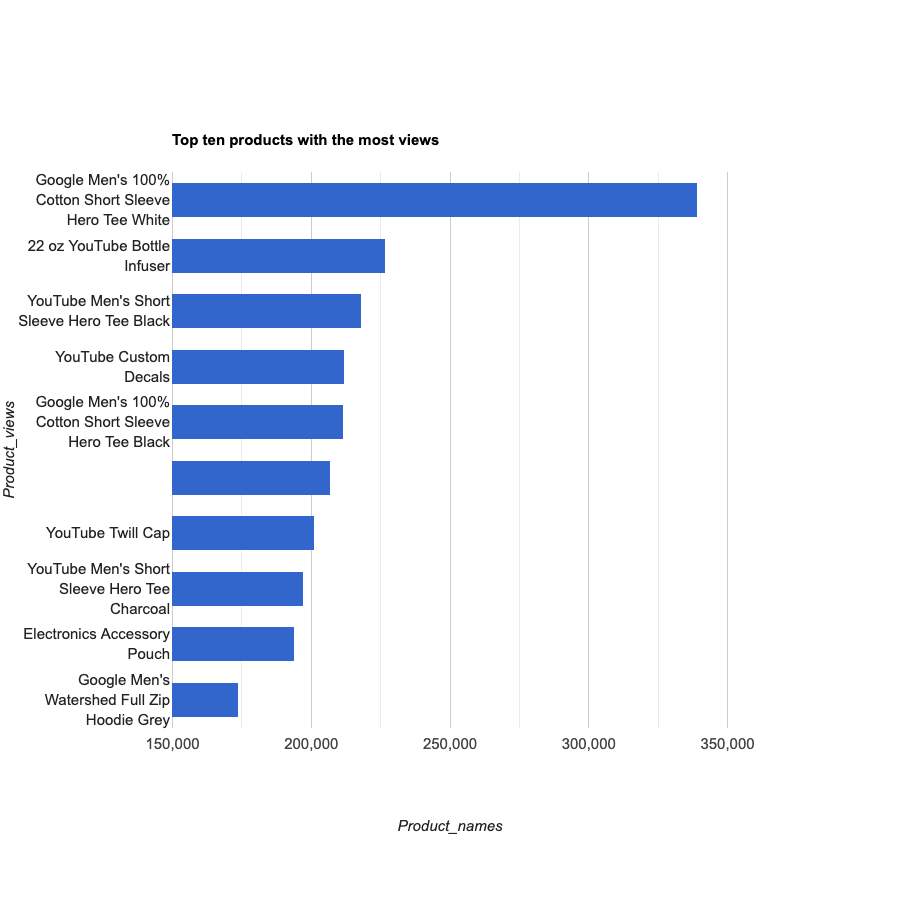

In [7]:
%chart bars -d most_viewed_products -f product_name,product_views
title: Top ten products with the most views
height: 900
width: 900
hAxis:
  title: Product_names
vAxis:
  title: Product_views
legend: none

## 1.5. The top 10 selling products? 

In [22]:
%bq query
SELECT 
  p.v2ProductName,
  p.v2ProductCategory,
  SUM(p.productQuantity) AS units_sold,
  ROUND(SUM(p.localProductRevenue/1000000),2) AS revenue
FROM `data-to-insights.ecommerce.web_analytics`,
UNNEST(hits) AS h,
UNNEST(h.product) AS p
GROUP BY 1, 2
ORDER BY revenue DESC
LIMIT 10;

v2ProductName,v2ProductCategory,units_sold,revenue
Nest® Learning Thermostat 3rd Gen-USA - Stainless Steel,Nest-USA,17651,870976.95
Nest® Cam Outdoor Security Camera - USA,Nest-USA,16930,684034.55
Nest® Cam Indoor Security Camera - USA,Nest-USA,14155,548104.47
Nest® Protect Smoke + CO White Wired Alarm-USA,Nest-USA,6394,178937.6
Nest® Protect Smoke + CO White Battery Alarm-USA,Nest-USA,6340,178572.4
Nest® Learning Thermostat 3rd Gen-USA - White,Nest-USA,1638,83114.76
Google 22 oz Water Bottle,Drinkware,49288,38302.75
Google Men's Zip Hoodie,Apparel,2253,38072.18
Nest® Learning Thermostat 3rd Gen - CA - Stainless Steel,Nest-Canada,662,35620.83
26 oz Double Wall Insulated Bottle,Drinkware,5323,35505.52


## 1.6. Write a query that shows the number of different eCommerceAction_type 
    * The mapping for the action type: 
    * Unknown = 0 
    * Click through of product lists = 1 
    * Product detail views = 2 
    * Add product(s) to cart = 3 
    * Remove product(s) from cart = 4 
    * Check out = 5 Completed purchase = 6 
    * Refund of purchase = 7 
    * Checkout options = 8

In [10]:
%bq query -n most_viewed_products
SELECT
  COUNT(*) as number_of_sessions,
  CASE h.eCommerceAction.action_type
      WHEN '0' THEN 'Unknown'
      WHEN '1' THEN 'Click through of product lists'
      WHEN '2' THEN 'Product detail views'
      WHEN '3' THEN 'Add product(s) to cart'
      WHEN '4' THEN 'Remove product(s) from cart'
      WHEN '5' THEN 'Check out'
      WHEN '6' THEN 'Completed purchase'
      WHEN '7' THEN 'Refund of purchase'
      WHEN '8' THEN 'Checkout options'
      ELSE 'ERROR'
      END AS action_type_label
FROM `data-to-insights.ecommerce.web_analytics`, UNNEST(hits) as h
GROUP BY h.eCommerceAction.action_type
ORDER BY number_of_sessions DESC

In [11]:
%bq execute -q most_viewed_products

number_of_sessions,action_type_label
3661298,Unknown
568642,Click through of product lists
464958,Product detail views
167279,Add product(s) to cart
157747,Check out
50399,Completed purchase
23285,Remove product(s) from cart


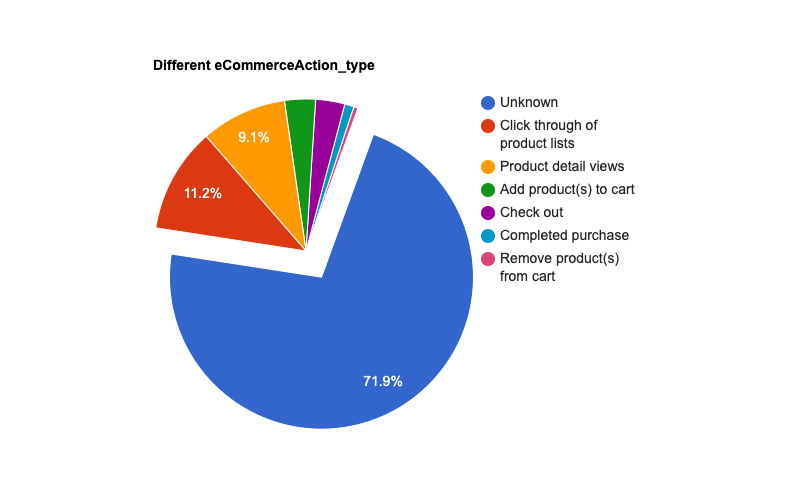

In [12]:
%chart pie --fields action_type_label,number_of_sessions --data most_viewed_products
title: Different eCommerceAction_type
height: 500
width: 800
pieStartAngle: 20
slices:
  0:
    offset: .2

## 1.7. Calculating revenue by month

In [13]:
%bq query -n month_revenue
SELECT
  FORMAT_DATE("%Y%m", parse_date('%Y%m%d', date)) as year_month,
  sum(h.transaction.transactionRevenue)/1000000 as revenue
FROM `data-to-insights.ecommerce.web_analytics`, unnest(hits) as h
where FORMAT_DATE("%Y%m", parse_date('%Y%m%d', date)) not like '201708'
Group by year_month
order by year_month

In [14]:
%bq execute -q month_revenue

year_month,revenue
201608,190437.27
201609,136756.07
201610,163908.21
201611,572101.33
201612,701428.59
201701,473770.4
201702,364283.53
201703,409341.47
201704,447735.4
201705,359327.83


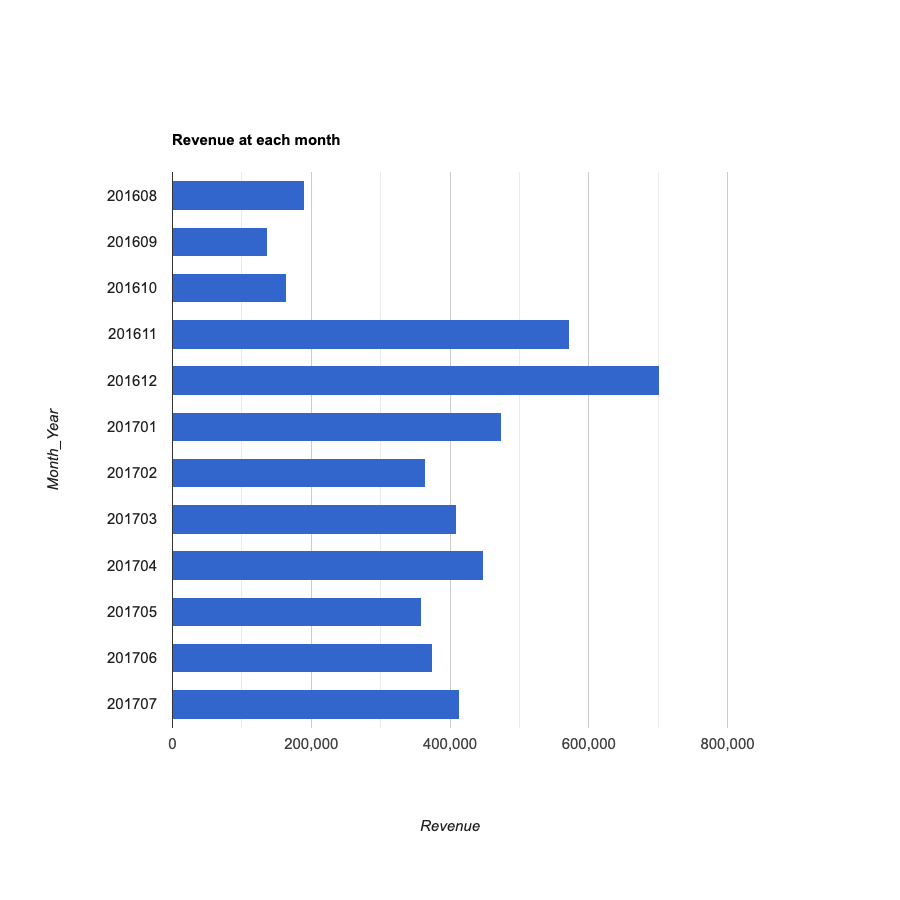

In [15]:
%chart bars --fields year_month,revenue --data month_revenue
title: Revenue at each month
height: 900
width: 900
hAxis:
  title: Revenue
vAxis:
  title: Month_Year
legend: none

## 1.8. How many % of the total visitors made a purchase?

In [21]:
%bq query
WITH visitors AS(
SELECT 
COUNT(DISTINCT fullVisitorId) AS number_visitors
FROM `data-to-insights.ecommerce.web_analytics`
),

purchasers AS(
SELECT 
COUNT(DISTINCT fullVisitorId) AS number_purchasers
FROM `data-to-insights.ecommerce.web_analytics`, UNNEST (hits) as h
WHERE h.eCommerceAction.action_type LIKE '6'
#WHERE totals.transactions IS NOT NULL
)

SELECT 
  number_visitors, 
  number_purchasers, 
  number_purchasers / number_visitors AS conversion_rate
FROM visitors, purchasers

number_visitors,number_purchasers,conversion_rate
741721,20015,0.026984540008979117


## 1.9. How many visitors bought on subsequent visits to our website?

In [20]:
%bq query
WITH all_visitor_stats AS (
SELECT
  fullvisitorid, # 741,721 unique visitors
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit 
  FROM `data-to-insights.ecommerce.web_analytics` 
  GROUP BY fullvisitorid
)
  
SELECT 
  COUNT(DISTINCT fullvisitorid) AS total_visitors,
  will_buy_on_return_visit
FROM all_visitor_stats
GROUP BY will_buy_on_return_visit

total_visitors,will_buy_on_return_visit
729848,0
11873,1


## 2. ML MOdel: Precdicting vistors who added products to cart and completed purchases
There are customers who add products to carts but they removed the products from the carts or log out. The customers don't complete the purchases. I try to create a LM model to predict whether the customers will complete the purchases after adding products to carts.

## 2.1. Model selection and feature engineering
Logistic classification model is selected. The feature used to train the model are: 
    1. Bounces
    2. Time on site
    3. If the customer visits the first time
    4. Number of page views
    5. Channel
    5. Type of devices 
    6. Where is the customer (country)
    7. Where the visitor come from: traffic source, traffic medium
    8. Unique session id 
    
 The data from the first nine months in the dataset is used to test train the model. 

In [ ]:
%bq query
CREATE OR REPLACE MODEL `eCommerce.model_2`
OPTIONS
  (model_type='logistic_reg', labels=['completed_purchases']) AS
  
SELECT
 CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
 IFNULL(totals.bounces,0) as bounces,
 IFNULL(totals.timeOnSite,0) as time_on_site,
 IFNULL(totals.newVisits,0) as newVisits,
 totals.pageviews,
 channelGrouping,
 device.deviceCategory, 
 IFNULL(geoNetwork.country, "") AS country,
 trafficSource.source,
 trafficSource.medium,
 CASE h.eCommerceAction.action_type
  WHEN '2' THEN 0
  WHEN '3' THEN 0
  WHEN '4' THEN 0
  WHEN '5' THEN 0
  WHEN '6' THEN 1
 END AS completed_purchases
FROM `data-to-insights.ecommerce.web_analytics`, UNNEST(hits) as h
WHERE  h.eCommerceAction.action_type IN ('2','3', '4','5','6') AND date BETWEEN '20160801' AND '20170430'

## 2.2. The model Evaluation 
The data in the next two months is used to evaluate the model

In [23]:
%bq query -n model_evaluation
SELECT
  roc_auc,
FROM
  ML.EVALUATE(MODEL eCommerce.model_2,  (

SELECT
 CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
 IFNULL(totals.bounces,0) as bounces,
 IFNULL(totals.timeOnSite,0) as time_on_site,
 IFNULL(totals.newVisits,0) as newVisits,
 totals.pageviews,
 channelGrouping,
 device.deviceCategory, 
 IFNULL(geoNetwork.country, "") AS country,
 trafficSource.source,
 trafficSource.medium,
 CASE h.eCommerceAction.action_type
  WHEN '2' THEN 0
  WHEN '3' THEN 0
  WHEN '4' THEN 0
  WHEN '5' THEN 0
  WHEN '6' THEN 1
 END AS completed_purchases
FROM `data-to-insights.ecommerce.web_analytics`, UNNEST(hits) as h
WHERE  h.eCommerceAction.action_type IN ('2','3', '4','5','6') AND date BETWEEN '20170501' AND '20170630'

));

In [24]:
%bq execute -q model_evaluation

roc_auc
0.6961748251748252


## 2.3. The model prediction
The data from the last month of the dataset is used to make prdection

In [25]:
%bq query
SELECT
*
FROM
  ml.PREDICT(MODEL `eCommerce.model_2`,
   (
SELECT
 CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
 IFNULL(totals.bounces,0) as bounces,
 IFNULL(totals.timeOnSite,0) as time_on_site,
 IFNULL(totals.newVisits,0) as newVisits,
 totals.pageviews,
 channelGrouping,
 device.deviceCategory, 
 IFNULL(geoNetwork.country, "") AS country,
 trafficSource.source,
 trafficSource.medium,
 CASE h.eCommerceAction.action_type
  WHEN '2' THEN 0
  WHEN '3' THEN 0
  WHEN '4' THEN 0
  WHEN '5' THEN 0
  WHEN '6' THEN 1
 END AS completed_purchases
FROM `data-to-insights.ecommerce.web_analytics`, UNNEST(hits) as h
WHERE  h.eCommerceAction.action_type IN ('2','3', '4','5','6') AND date BETWEEN '20170701' AND '20170801'

));

predicted_completed_purchases,unique_session_id,bounces,time_on_site,newVisits,pageviews,channelGrouping,deviceCategory,country,source,medium,completed_purchases
0,20173284039316232051500841878,0,0,1,1,Display,mobile,United States,dfa,cpm,0
0,50068196974874376461500943632,0,15,0,2,Display,desktop,Canada,dfa,cpm,0
0,6934426490330358621499396311,0,9,1,2,Organic Search,desktop,United States,google,organic,0
0,52377527447784105291499052470,0,1176,0,2,Organic Search,desktop,China,google,organic,0
0,70663975567657879671501505327,0,9,1,2,Organic Search,desktop,United States,google,organic,0
0,64075712466580741741499390328,0,57,1,2,Organic Search,desktop,United States,google,organic,0
0,27416445002525653271498970474,0,11,1,2,Organic Search,mobile,Thailand,google,organic,0
0,95479140513857942031501328155,0,4,1,2,Organic Search,mobile,United Kingdom,google,organic,0
0,07993939181471420281500957011,0,3,1,2,Organic Search,mobile,United States,google,organic,0
0,24446199326313146331499790891,0,3,1,2,Organic Search,mobile,Sweden,google,organic,0
